## Example of Jupyter/Ginga widget

This is an example of creating a Jupyter data viewer widget using a Jupyter image
widget and the Ginga viewer toolkit.

In [1]:
# create a Jupyter image that will be our display surface
# format can be 'jpeg' or 'png'; specify width and height to set viewer size
# PNG will be a little clearer, especially with overlaid graphics, but
# JPEG is faster to update
import ipywidgets as widgets
jup_img = widgets.Image(format='jpeg', width=500, height=500)

In [2]:
# Boilerplate to create a Ginga viewer connected to this widget
# this could be simplified, or hidden behind a class or convenience 
# method
# NOTE: you don't have to specify a log file--and if you are not interested
# in the log just specify null=True for a null logger
# level=10 will give you the most debugging information
from ginga.misc.log import get_logger
logger = get_logger("my viewer", log_stderr=False, log_file='/tmp/ginga.log', level=40)

from ginga.web.jupyterw.ImageViewJpw import EnhancedCanvasView
v1 = EnhancedCanvasView(logger=logger)
# set our linkage between the jupyter widget at ginga
v1.set_widget(jup_img)

# enable all possible keyboard and pointer operations
bd = v1.get_bindings()
bd.enable_all(True)

In [3]:
coordinates = widgets.HTML('<h3>coordinates show up here</h3>')

# callback to display position in RA/DEC deg
def mouse_move(viewer, button, data_x, data_y, w):
    image = viewer.get_image()
    if image is not None:
        ra, dec = image.pixtoradec(data_x, data_y)
        w.value = "cursor at %f, %f" % (ra, dec)

v1.add_callback('motion', mouse_move, coordinates)


In [4]:
# embed the viewer here

widgets.VBox([jup_img, coordinates])

VBox(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x01\xf4\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe1\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf1\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xc4\x00\x1f\x01\x00\x03\x01\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x11\x00\x02\x01\x02\x04\x04\x03\x04\x07\x05\x04\x04\x00\x01\x02w\x00\x01\x02\x03\x11\x04\x05!1\x06\x12AQ\x07aq\x13"2\x81\x08\x14B\x91\xa1\xb1\xc1\t#3R\xf0\x15br\xd1\n\x16$4\xe1%\xf1\x17\x18\x19\x1a&\'()*56789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x82\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00\xf9R\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x02\x8a(\xa0\x

In [5]:
# Load a FITS file.  You should see the embedded image update.
v1.load_fits("/home/eric/testdata/SPCAM/SUPA01118766.fits")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


You can now do nearly everything that can be done with a regular "pg" type ginga web widget.
See http://ginga.readthedocs.io/en/latest/quickref.html for default key and button/pointer bindings.

See https://github.com/ejeschke/ginga/blob/master/ginga/examples/jupyter-notebook/ginga_ipython_demo.ipynb
for the kinds of things you can do with the embedded viewer including graphics overplotting, etc.

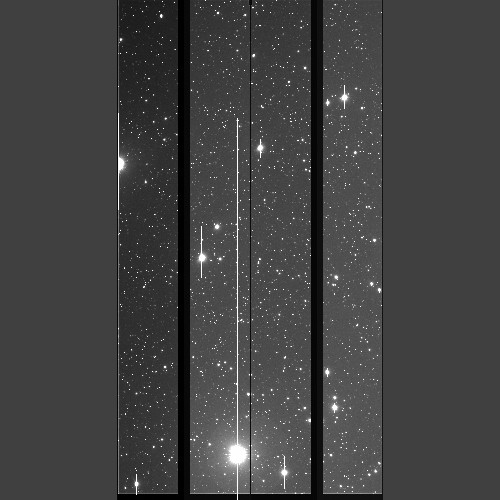

In [6]:
# grab a screenshot.
v1.show()

In [7]:
# add a canvas to the image and set the draw type
canvas = v1.add_canvas()
canvas.set_drawtype('ellipse', color='orange', fill=True, fillcolor='cyan', fillalpha=0.3)

Now press and release space bar in the viewer and draw the shape.  Or you can use the right mouse button.

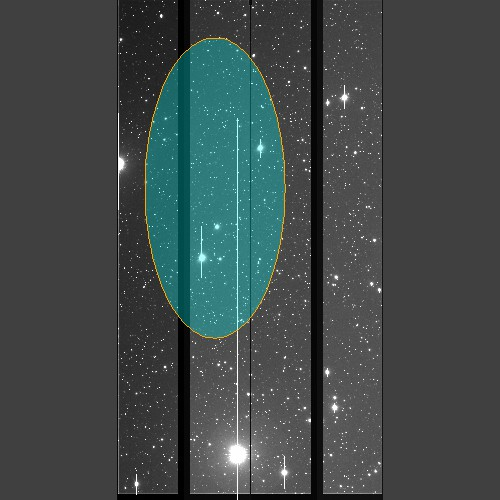

In [8]:
v1.show()

In [9]:
# put the canvas in edit mode
canvas.enable_edit(True)
canvas.set_draw_mode('edit')

Now you can click on the object to select it and edit it.  Editing control points should appear:
- orange: stretch or shrink dimension(s)
- green: scale object while keeping aspect
- blue: rotate object
- red: move object
You can also move objects simply by dragging anywhere in the bounding box if they are selected.

In [10]:
canvas.get_objects()

In [11]:
# let's get the object that we drew--what is it's location?
ell = canvas.get_objects()[0]
ell.x, ell.y

(811.32799999999997, 2512.4360000000001)

In [12]:
ell.xradius, ell.yradius

(315.08199669919026, 1050.8094932699062)

In [15]:
# delete everything on the canvas that we drew
canvas.delete_all_objects()